<a href="https://colab.research.google.com/github/SergioPGJunior/Reconhecimento-de-emocoes-na-fala-com-audios-em-Portugues/blob/main/projeto_SER.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

In [ ]:
# Executa o upgrade da versão da biblioteca librosa no Colab
! pip install --upgrade librosa

In [12]:
#import de todas as bibliotecas e funções utilizadas no projeto
import librosa
import numpy as np
import pandas as pd
from sklearn import feature_extraction, linear_model, model_selection, preprocessing, svm, metrics
from matplotlib import pyplot as plt
from sklearn.ensemble import RandomForestClassifier
from sklearn.preprocessing import StandardScaler
from sklearn.decomposition import PCA
from sklearn.model_selection import train_test_split
from sklearn.model_selection import StratifiedShuffleSplit
from sklearn.model_selection import GridSearchCV
import os

In [6]:
#Cria as funções que executam a extração de parâmetros dos áudios da base

def matriz_mfcc(y,fs, n_mfcc=12,delta=False,delta2=False):

  mfcc = librosa.feature.mfcc(y, fs, n_mfcc=n_mfcc)
  
  if delta == True & delta2 == True:
    mfcc_delta = librosa.feature.delta(mfcc)
    mfcc_delta2 = librosa.feature.delta(mfcc,order=2)
    parametros = np.concatenate((mfcc, mfcc_delta,mfcc_delta2))
    
  elif delta == True:
    mfcc_delta = librosa.feature.delta(mfcc)
    parametros = np.concatenate((mfcc, mfcc_delta))

  elif delta2 == True:
    mfcc_delta2 = librosa.feature.delta(mfcc,order=2)
    parametros = np.concatenate((mfcc, mfcc_delta2))

  else:
    parametros = mfcc

  return parametros.tolist()

def parametros_globais(vetor_parametros):

  media = np.mean(vetor_parametros,axis=1).transpose()
  mediana = np.median(vetor_parametros,axis=1).transpose()
  maximo = np.amax(vetor_parametros,axis=1).transpose()
  minimo = np.amin(vetor_parametros,axis=1).transpose()
  std = np.std(vetor_parametros,axis=1).transpose()

  return np.concatenate((media, mediana, maximo, minimo, std)).tolist()

In [ ]:
''' Extração de parâmetros '''

#Executa a extração de parâmetros e salva os dados em um Dataframe
path = "/content/drive/MyDrive/Banco de Dados/"
actors = ['Clara', 'Getúlio', 'Marcos', 'Mauro', 'Nívea', 'Patricia', 'Renato', 'Stella']
emotions = ['Felicidade', 'Neutra', 'Raiva', 'Tristeza']

columns= ['actor','emotion','filename','parametros']
df = pd.DataFrame(columns = columns)

for actor in actors:
  for emotion in emotions: 
    files = os.scandir(path + actor + '/' + emotion)
    for file in files:
      try:
        y, fs = librosa.load(file)
        # yt, index = librosa.effects.trim(y, top_db=38)
        mfcc = matriz_mfcc(y,fs,20,delta=False,delta2=False)
        # mfcc = matriz_mfcc(yt,fs,20,delta=True,delta2=False)
        parametros = parametros_globais(mfcc)
        values = [actor, emotion, file, parametros]
        df = df.append(dict(zip(columns, values)),True)
      except:
        print('O arquivo {}, do ator {}, com a emoção {} não pode ser lido'.format(file,actor,emotion))
      
#Gera a coluna alvo
df['target'] = 0
df.loc[df['emotion'] =='Neutra','target'] = 1
df.loc[df['emotion']=='Raiva','target'] = 2
df.loc[df['emotion']=='Tristeza','target'] = 3


In [9]:
''' Tratamento dos dados '''

#Extrai a matriz com os dados de entrada para os classificadores
X = np.array(df['parametros'].tolist())

#Executa o escalonamento dos dados
scaler = StandardScaler()
scaler.fit(X)
X = scaler.transform(X)

#Análise dos componentes principais
pca = PCA(n_components=40) #O valor de 40 componentes foi alcançado após testes
pca.fit(X)

X = pca.transform(X)

ratio = pca.explained_variance_ratio_

print('Variância explicada: ',sum(ratio))

Variância explicada:  0.9473478844766023


In [10]:
''' SVM '''

#Busca em grade para identificar os melhores valores para os parâmetros C e gamma
X_train, X_test, y_train, y_test = train_test_split(X, df['target'],
                                                    test_size=0.3)

C_range = np.logspace(-2, 10, 13)
gamma_range = np.logspace(-9, 3, 13)
param_grid = dict(gamma=gamma_range, C=C_range)
cv = StratifiedShuffleSplit(n_splits=5, test_size=0.2, random_state=42)
grid = GridSearchCV(svm.SVC(kernel='rbf'), param_grid=param_grid, cv=cv)
grid.fit(X_train, y_train)


print("Os melhores parâmetros são %s com um score de %0.2f"
      % (grid.best_params_, grid.best_score_))

Os melhores parâmetros são {'C': 10.0, 'gamma': 0.01} com um score de 0.90


Acurácia de teste:  0.9122807017543859


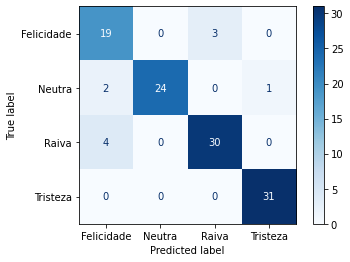

In [14]:
#Etapa de teste com SVM
predicted = grid.predict(X_test)
print('Acurácia de teste: ',metrics.accuracy_score(y_test, predicted))

class_names = ['Felicidade','Neutra', 'Raiva', 'Tristeza']

metrics.plot_confusion_matrix(grid, X_test, y_test,display_labels=class_names,
                                 cmap=plt.cm.Blues)
plt.show()

In [15]:
''' Random Forest '''

#Busca em grade para identificar os melhores valores para os parâmetros max_depth
#e n_estimators

depth_range = range(5,31,5)
n_estimators_range = range(10, 101, 10)
param_grid = dict(max_depth=depth_range, n_estimators=n_estimators_range)
cv = StratifiedShuffleSplit(n_splits=5, test_size=0.2, random_state=42)
grid = GridSearchCV(RandomForestClassifier(), param_grid=param_grid, cv=cv)
grid.fit(X_train, y_train)


print("Os melhores parâmetros são %s com um score de %0.2f"
      % (grid.best_params_, grid.best_score_))

Os melhores parâmetros são {'max_depth': 10, 'n_estimators': 90} com um score de 0.84


Acurácia de teste:  0.7807017543859649


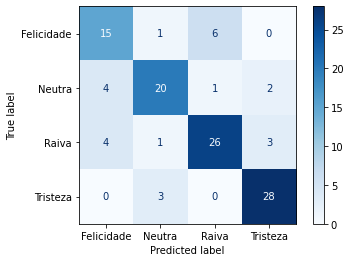

In [18]:
#Etapa de teste com Random Forest

predicted = grid.predict(X_test)
print('Acurácia de teste: ',metrics.accuracy_score(y_test, predicted))

class_names = ['Felicidade','Neutra', 'Raiva', 'Tristeza']

metrics.plot_confusion_matrix(grid, X_test, y_test,display_labels=class_names,
                                 cmap=plt.cm.Blues)
plt.show()